# Forecasting with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c06_forecasting_with_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c06_forecasting_with_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [0]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  
  
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

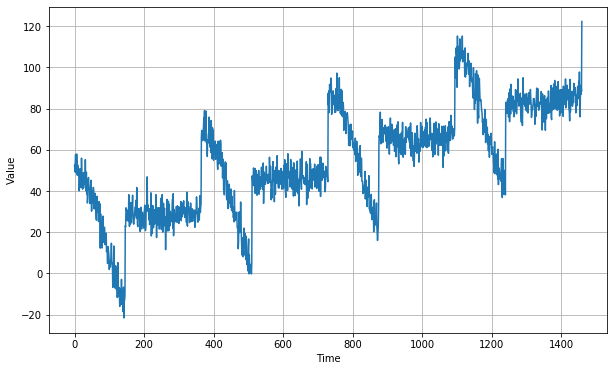

In [5]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [0]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Simple RNN Forecasting

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# set window size and train set
window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)

# simple RNN model
model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                      input_shape=[None]), # “None” means that the RNN can take sequences at any length
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100), # this layer we have return_sequence as False, so this is sequence to vector
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0) # add the lambda layer to account for our data shape. Scaling the output by 200 helps training
])

# test out learning rate, start at 10^-7 and increase it by 10x every 20 epochs
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))

# optimizer
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)

# train
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 233ms/step - loss: 49.6371 - mae: 50.8963
Epoch 2/100
8/8 [==============================] - 0s 55ms/step - loss: 22.8816 - mae: 23.2030
Epoch 3/100
8/8 [==============================] - 0s 51ms/step - loss: 19.4101 - mae: 19.5124
Epoch 4/100
8/8 [==============================] - 0s 49ms/step - loss: 16.8362 - mae: 17.3120
Epoch 5/100
8/8 [==============================] - 0s 49ms/step - loss: 15.6860 - mae: 16.1971
Epoch 6/100
8/8 [==============================] - 0s 51ms/step - loss: 15.1294 - mae: 15.5585
Epoch 7/100
8/8 [==============================] - 0s 47ms/step - loss: 14.5319 - mae: 14.9520
Epoch 8/100
8/8 [==============================] - 0s 51ms/step - loss: 14.0056 - mae: 14.6318
Epoch 9/100
8/8 [==============================] - 0s 53ms/step - loss: 13.6949 - mae: 14.4190
Epoch 10/100
8/8 [==============================] - 0s 51ms/step - loss: 13.4131 - mae: 14.0410
Epoch 11/100
8/8 [==============================

[1e-07, 0.0001, 0, 50]

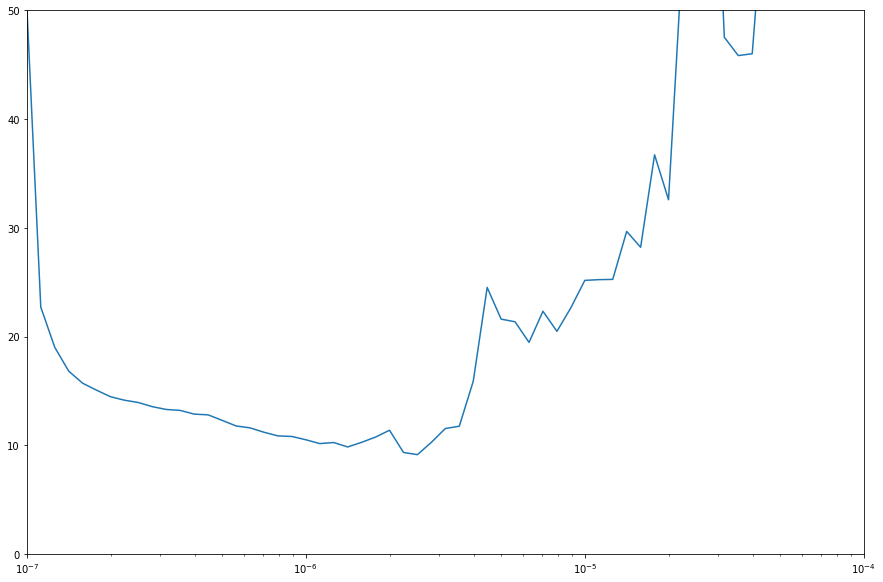

In [14]:
plt.figure(figsize=(15, 10))
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 50])

In [15]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# set window size and train & valid sets
window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

# simple RNN model
model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]), # “None” means that the RNN can take sequences at any length
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100), # this layer we have return_sequence as False, so this is sequence to vector
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0) # add the lambda layer to account for our data shape. Scaling the output by 200 helps training
])

# optimizer
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9) # use learning rate of 10^-6 based on above chart

# train model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Training RNN is pretty tricky. Its either time consuming or hard to train. And the error will jump around, not slowly improve. 
# To save the best version, we should use the following call back to save checkpoints after each time the model improve.
# Also increase teh patience size since the errors will jump around a bit
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 2s 228ms/step - loss: 56.5080 - mae: 56.7920 - val_loss: 15.4326 - val_mae: 15.8590
Epoch 2/500
8/8 [==============================] - 1s 68ms/step - loss: 33.4555 - mae: 34.8193 - val_loss: 12.3423 - val_mae: 12.6800
Epoch 3/500
8/8 [==============================] - 1s 64ms/step - loss: 27.6529 - mae: 28.0499 - val_loss: 29.4943 - val_mae: 29.7966
Epoch 4/500
8/8 [==============================] - 1s 68ms/step - loss: 20.1828 - mae: 20.8511 - val_loss: 24.0693 - val_mae: 24.9211
Epoch 5/500
8/8 [==============================] - 1s 68ms/step - loss: 16.4437 - mae: 17.1347 - val_loss: 11.3346 - val_mae: 11.9201
Epoch 6/500
8/8 [==============================] - 1s 64ms/step - loss: 13.4351 - mae: 14.0977 - val_loss: 6.6300 - val_mae: 7.0942
Epoch 7/500
8/8 [==============================] - 1s 66ms/step - loss: 12.1270 - mae: 12.5423 - val_loss: 9.1243 - val_mae: 9.6650
Epoch 8/500
8/8 [==============================] - 1s 66ms/step -

In [0]:
model = keras.models.load_model("my_checkpoint.h5")

In [0]:
rnn_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

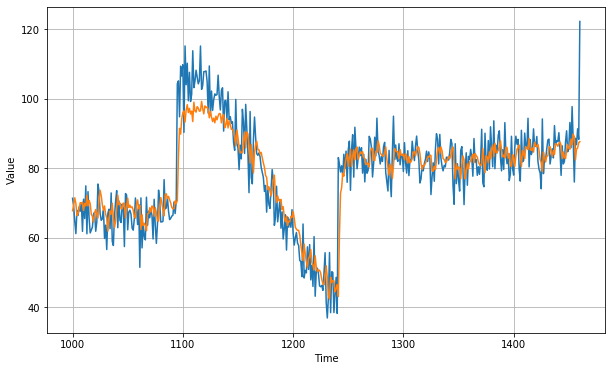

In [18]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [19]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.2757716

## Sequence-to-Sequence Forecasting

In [0]:
# create a function that converts datasets to sequence to sequence

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [22]:
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 3,
                                               batch_size=1):
    print("X:", X_batch.numpy())
    print("Y:", Y_batch.numpy())

X: [[[1]
  [2]
  [3]]]
Y: [[[2]
  [3]
  [4]]]
X: [[[2]
  [3]
  [4]]]
Y: [[[3]
  [4]
  [5]]]
X: [[[4]
  [5]
  [6]]]
Y: [[[5]
  [6]
  [7]]]
X: [[[3]
  [4]
  [5]]]
Y: [[[4]
  [5]
  [6]]]
X: [[[5]
  [6]
  [7]]]
Y: [[[6]
  [7]
  [8]]]
X: [[[6]
  [7]
  [8]]]
Y: [[[7]
  [8]
  [9]]]
X: [[[0]
  [1]
  [2]]]
Y: [[[1]
  [2]
  [3]]]


In [23]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# define window size and use the above seq2seq function to create train set
window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

# use simple RNN to test out the learning rate
model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])

# test out learning rate
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30))

# optimise
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)

# train
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 207ms/step - loss: 51.8009 - mae: 53.0830
Epoch 2/100
8/8 [==============================] - 0s 54ms/step - loss: 25.6186 - mae: 25.9613
Epoch 3/100
8/8 [==============================] - 0s 51ms/step - loss: 23.2628 - mae: 23.7152
Epoch 4/100
8/8 [==============================] - 0s 52ms/step - loss: 20.7639 - mae: 21.3966
Epoch 5/100
8/8 [==============================] - 0s 56ms/step - loss: 19.3458 - mae: 19.9318
Epoch 6/100
8/8 [==============================] - 0s 51ms/step - loss: 18.7027 - mae: 19.1986
Epoch 7/100
8/8 [==============================] - 0s 52ms/step - loss: 18.1732 - mae: 18.6635
Epoch 8/100
8/8 [==============================] - 0s 57ms/step - loss: 17.6910 - mae: 18.2660
Epoch 9/100
8/8 [==============================] - 0s 61ms/step - loss: 17.3617 - mae: 17.9216
Epoch 10/100
8/8 [==============================] - 0s 54ms/step - loss: 16.9487 - mae: 17.5786
Epoch 11/100
8/8 [==============================

[1e-07, 0.0001, 0, 30]

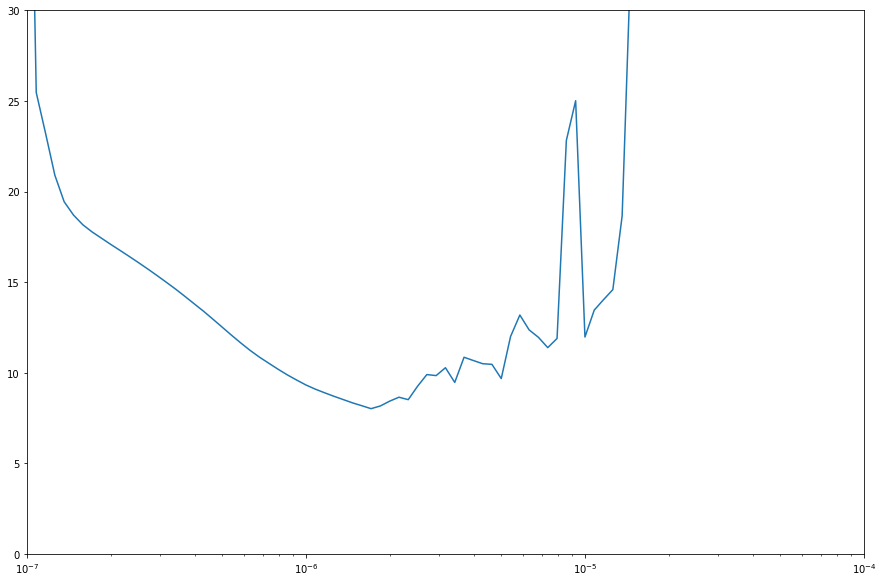

In [24]:
plt.figure(figsize=(15, 10))
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [25]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# define window size and use the above seq2seq function to create train set
window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

# sequence to sequence RNN
model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True), # this layer we have return_sequence as TRUE, so this is sequence to sequence
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])

# optimize
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9) # use learning rate of 10^-6 as seen in the above graph

# train with early stopping
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
8/8 [==============================] - 2s 239ms/step - loss: 55.8513 - mae: 56.2826 - val_loss: 17.6785 - val_mae: 18.0197
Epoch 2/500
8/8 [==============================] - 1s 65ms/step - loss: 33.9155 - mae: 35.1114 - val_loss: 17.4470 - val_mae: 18.0774
Epoch 3/500
8/8 [==============================] - 1s 67ms/step - loss: 28.3637 - mae: 28.6514 - val_loss: 35.8524 - val_mae: 36.0963
Epoch 4/500
8/8 [==============================] - 1s 66ms/step - loss: 21.0046 - mae: 21.6919 - val_loss: 27.8288 - val_mae: 28.4823
Epoch 5/500
8/8 [==============================] - 1s 68ms/step - loss: 17.9119 - mae: 18.5032 - val_loss: 17.8702 - val_mae: 18.4260
Epoch 6/500
8/8 [==============================] - 1s 66ms/step - loss: 15.3044 - mae: 15.8192 - val_loss: 10.6281 - val_mae: 11.1624
Epoch 7/500
8/8 [==============================] - 1s 67ms/step - loss: 13.8782 - mae: 14.3735 - val_loss: 8.7739 - val_mae: 9.2796
Epoch 8/500
8/8 [==============================] - 1s 71ms/step

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

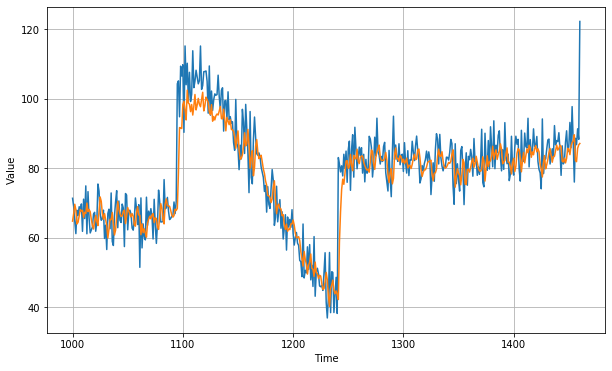

In [27]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [28]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.1336346